<a href="https://colab.research.google.com/github/steimel60/ML/blob/main/DeepLearning/CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *

     |████████████████████████████████| 719 kB 20.3 MB/s 
     |████████████████████████████████| 1.2 MB 39.9 MB/s 
     |████████████████████████████████| 4.4 MB 18.1 MB/s 
     |████████████████████████████████| 362 kB 48.9 MB/s 
     |████████████████████████████████| 86 kB 2.1 MB/s 
     |████████████████████████████████| 212 kB 29.3 MB/s 
     |████████████████████████████████| 1.1 MB 36.2 MB/s 
     |████████████████████████████████| 140 kB 48.3 MB/s 
     |████████████████████████████████| 596 kB 42.4 MB/s 
     |████████████████████████████████| 127 kB 47.4 MB/s 
     |████████████████████████████████| 144 kB 37.9 MB/s 
     |████████████████████████████████| 271 kB 44.7 MB/s 
     |████████████████████████████████| 94 kB 2.4 MB/s 
     |████████████████████████████████| 6.6 MB 47.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.

We can use Kernels (small matrices of -1s, 0s, and 1s) to search for edges in our image - a common trait of certain numbers

In [2]:
#Make our kernel
top_edge = tensor([[-1,-1,-1],
                   [0,0,0],
                   [1,1,1]]).float()

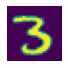

In [3]:
#Get an image
path = untar_data(URLs.MNIST_SAMPLE)
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3)

In [4]:
im3_t = tensor(im3)
im3_t[0:3,0:3] * top_edge #Multiply a section of our image by our top edge matrix filter

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [5]:
(im3_t[0:3,0:3] * top_edge).sum() #Note our top corner was empty so we get all 0s

tensor(0.)

In [6]:
#Lets get more interesting part of image
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [7]:
def apply_kernel(row, col, kernel):
  return (im3_t[row-1:row+2, col-1:col+2] * kernel).sum()
apply_kernel(5,7,top_edge)

tensor(762.)

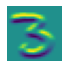

In [8]:
#Apply kernel to entire image
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3)

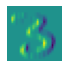

In [9]:
#We can also do this with vertical edges
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]])
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3)

In [10]:
#speed it up with PyTorch
diag1_edge = tensor([[0,-1,1],
                     [-1,1,0],
                     [1,0,0]]).float()
diag2_edge = tensor([[1,-1,0],
                     [0,1,-1],
                     [0,0,1]]).float()
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape #PyTorch wants rank 4 tensor to speed things up so we stack our kernels

torch.Size([4, 3, 3])

In [11]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(),
                  get_y = parent_label)
dls = mnist.dataloaders(path)
xb, yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [12]:
#move to cpu
xb, yb = to_cpu(xb), to_cpu(yb)
#Turn our rank3 tensor into rank 4 (effectively adding "channels_in" parameter)
edge_kernels = edge_kernels.unsqueeze(1)
#Pass to PyTorchs convolution function (what we've done above but fast)
batch_features = F.conv2d(xb,edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

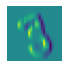

In [13]:
show_image(batch_features[0,0])

##Using convolutions instead of or in addition to linear layers creates a Convolutional Neural Network (CNN)

In [14]:
#Load in basic NN
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [15]:
#Use Conv2d to create convolutional nn
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)
#define func using params we use in simpe convolutions
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

In [16]:
#Comments to show size of activation map after each layer
simple_cnn = sequential(
    conv(1, 4), #14x14
    conv(4,8),  #7x7
    conv(8, 16),#4x4
    conv(16,32),#2x2
    conv(32,2,act=False), #1x1
    Flatten()
)

In [17]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [18]:
#see if it trains
learn.fit_one_cycle(2, .01)

epoch,train_loss,valid_loss,accuracy,time
0,0.057628,0.041029,0.988714,00:24
1,0.022025,0.021646,0.992640,00:15


##Now lets do all 10 digits

In [19]:
path = untar_data(URLs.MNIST)

In [20]:
def get_dls(bs=64):
  return DataBlock(
      blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
      get_items=get_image_files,
      splitter = GrandparentSplitter('training','testing'),
      get_y=parent_label,
      batch_tfms=Normalize()
  ).dataloaders(path, bs=bs)

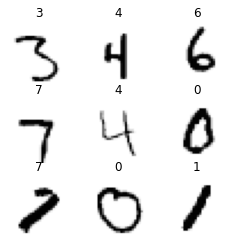

In [22]:
dls = get_dls()
dls.show_batch(max_n=9, figsize=(4,4))

we want more activations because we are learning more digits. Right now we have a kernel of 9 pixels so if we double our outputs (from 4 to 8) then we will be using  inputs to create 8 outputs - which means we wont learn very much. So we need to increase our kernel size

In [23]:
def simple_cnn():
  return sequential(
      conv(1, 8,ks=5),    #14x14
      conv(8, 16),        #7x7
      conv(16,32),        #4x4
      conv(32,64),        #2x2
      conv(64,10,act=False),#1x1
      Flatten(),
  )

In [24]:
from fastai.callback.hook import *

In [25]:
def fit(epochs=1):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
  learn.fit(epochs, .06)
  return learn

learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.304446,2.311208,0.102800,01:29


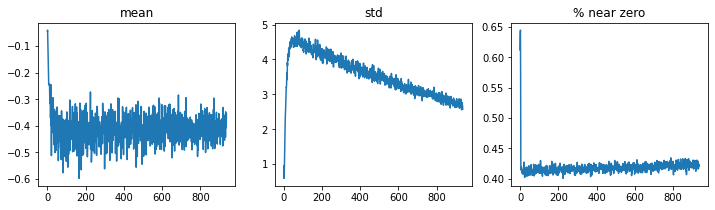

In [26]:
#Plot activation stats of layer idx 0
learn.activation_stats.plot_layer_stats(0)

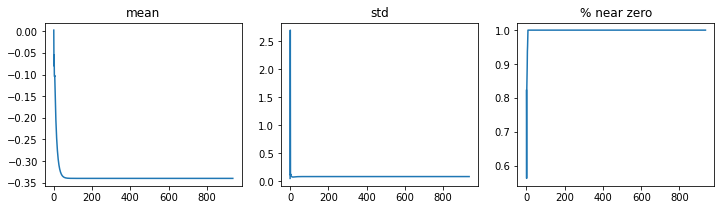

In [28]:
#Same for penultimate layer
learn.activation_stats.plot_layer_stats(-2)

Activations near zero are problematic, one possible solution is to increase batch size

In [29]:
dls = get_dls(512)
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.312017,2.301486,0.113500,01:08


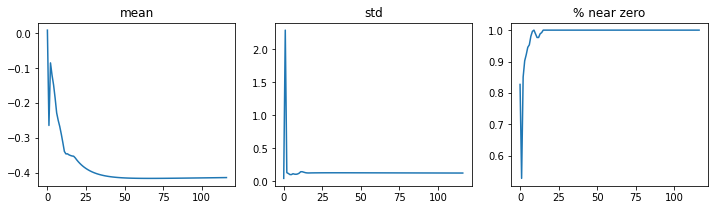

In [30]:
#See if it helped
learn.activation_stats.plot_layer_stats(-2)

It has helped a little but still not great. Next we will try 1cycle training. Using slow learning rates at the beginning and ends but a large learning rate in the middle to speed up learning and smooth out local mins and maxes.

In [31]:
def fit(epochs=1, lr=.06):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy,cbs=ActivationStats(with_hist=True))
  learn.fit_one_cycle(epochs, lr) #fit_one_cycle automatically uses this technique
  return learn
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.198404,0.072186,0.977400,01:17


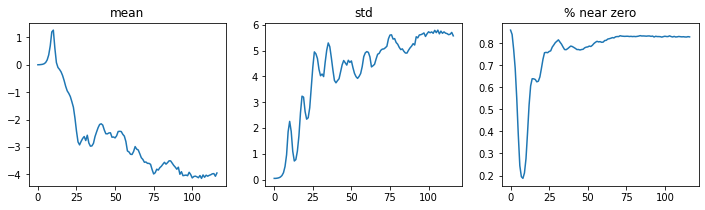

In [32]:
#see if it helped
learn.activation_stats.plot_layer_stats(-2)

Better but still not great and we also want a smoother curve. Batch normilzation may help

In [33]:
def conv(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  layers.append(nn.BatchNorm2d(nf))
  if act: layers.append(nn.ReLU())
  return nn.Sequential(*layers)

learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.130250,0.058199,0.986400,01:13


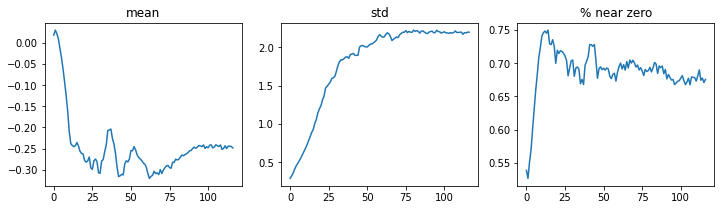

In [34]:
learn.activation_stats.plot_layer_stats(-2)

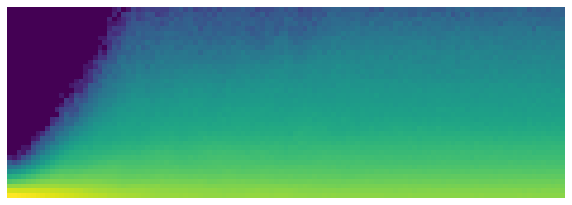

In [35]:
#color_dim will show us the "smoothness"
learn.activation_stats.color_dim(-4)

we now have less 0 activations and a smooth development of activations!